In [1]:
import os
import sys
import gzip
import random
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch, torch.nn as nn
import tqdm
from torch import optim
from torch.nn.functional import ctc_loss, log_softmax
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose
from torchvision import models
import editdistance
from torch.backends import cudnn
from made2_hw2_baseline_recogintion import get_logger, train, eval, abc, is_valid_str, convert_to_eng, Compose, Resize, Pad, Rotate


def reseed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [2]:
INPUT_FOLDER = '../input/made2-hw2-recognition-train-data/'

TRAIN_META = os.path.join(INPUT_FOLDER, f"train_meta.csv")
TRAIN_CROPS = os.path.join(INPUT_FOLDER, f"train_crops.npz")

TEST_META = os.path.join(INPUT_FOLDER, f"test_meta.csv")
TEST_CROPS = os.path.join(INPUT_FOLDER, f"test_crops.npz")

SUBMISSION_TEMPLATE = '../input/car-plates-ocr-made/submission.csv'

VAL_SPLIT = 0.2

START_CHECKPOINT = None

LR = 3E-3
WEIGHT_DECAY = 1E-4

LR_STEP = 10
LR_GAMMA = 0.5

EPOCHS = 100 # *110s

RNN_DROPOUT = 0.1
RNN_NUM_DIRECTIONS = 2

# augmentations
MAX_ROTATION = 20
P_ROTATION = 0.3

MAX_PAD = 0.1
P_PAD = 0.3

MODEL = 'resnet18'
CROP_H = 32
CROP_SIZE = (CROP_H*10, CROP_H)

if MODEL=='resnet50' and CROP_H==64:
    def build_FE():
        resnet = getattr(models, MODEL)(pretrained=True)
        return nn.Sequential(*(list(resnet.children())[:-2]+[nn.Conv2d(2048, 512, kernel_size=2, stride=2), nn.ReLU()]))
    BATCH_SIZE = 128
    reseed(42)
elif MODEL=='resnet50' and CROP_H==32:
    def build_FE():
        resnet = getattr(models, MODEL)(pretrained=True)
        return nn.Sequential(*(list(resnet.children())[:-2]+[nn.Conv2d(2048, 512, kernel_size=1, stride=1), nn.ReLU()]))
    BATCH_SIZE = 128
    reseed(43)
elif MODEL=='resnet18' and CROP_H==32:
    def build_FE():
        resnet = getattr(models, MODEL)(pretrained=True)
        return nn.Sequential(*list(resnet.children())[:-2])
    BATCH_SIZE = 256
    reseed(44)
elif MODEL=='resnet18' and CROP_H==64:
    def build_FE():
        resnet = getattr(models, MODEL)(pretrained=True)
        return nn.Sequential(*(list(resnet.children())[:-2]+[nn.Conv2d(512, 512, kernel_size=2, stride=2), nn.ReLU()]))
    BATCH_SIZE = 256
    reseed(45)

In [3]:
class RecognitionDataStorage(Dataset):

    def __init__(self, meta_file, crops_file, limit=None, only_valid=True):
        super(RecognitionDataStorage, self).__init__()
        
        self.df = pd.read_csv(meta_file)
        self.df.sort_values('index', inplace=True)
        self.df.set_index('index', inplace=True)
        with np.load(crops_file) as data:
            self.images = data['crops']
        assert (self.df.shape[0]==self.images.shape[0])
        self.df['text'] = self.df.text.apply(lambda txt: self.prepare_text(txt))
        if only_valid:
            self.good_indices = self.df.index[self.df.text.apply(lambda txt: txt!="" and is_valid_str(txt))]
        else:
            self.good_indices = np.arange(self.df.shape[0])

    @staticmethod
    def prepare_text(txt):
        return convert_to_eng(str(txt).upper())

    def __len__(self):
        return len(self.good_indices)

    def __getitem__(self, item):
        idx = self.good_indices[item]
        return self.images[idx], self.df.loc[idx,'text'], self.df.loc[idx,'filename'], self.df.loc[idx,'crop_idx']


class RecognitionDataset(Dataset):

    def __init__(self, storage, indices, abc=abc, transforms=None):
        super(RecognitionDataset, self).__init__()
        self.storage = storage
        self.indices = indices
        self.abc = abc
        self.transforms = transforms

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, item):
        image, text, filename, order = self.storage[self.indices[item]]

        seq = self.text_to_seq(text)
        seq_len = len(seq)
        output = dict(image=image.astype(np.float32) / 255., seq=seq, seq_len=seq_len, text=text, filename=filename, order=order)
        
        if self.transforms is not None:
            output = self.transforms(output)
            
        return output

    def text_to_seq(self, text):
        seq = [self.abc.find(c) + 1 for c in text]
        return seq

    @staticmethod
    def collate_fn(batch):
        images = list()
        seqs = list()
        seq_lens = list()
        filenames = list()
        orders = list()
        for sample in batch:
            images.append(torch.from_numpy(sample["image"].transpose((2, 0, 1))).float())
            seqs.extend(sample["seq"])
            seq_lens.append(sample["seq_len"])
            filenames.append(sample["filename"])
            orders.append(sample["order"])
        images = torch.stack(images)
        seqs = torch.Tensor(seqs).int()
        seq_lens = torch.Tensor(seq_lens).int()
        batch = {"images": images, "seqs": seqs, "seq_lens": seq_lens, 'filenames':filenames, 'orders':orders}
        return batch

In [4]:
%%time
data_storage = RecognitionDataStorage(TRAIN_META, TRAIN_CROPS, limit=None, only_valid=True)
print(len(data_storage))

123252
CPU times: user 34.3 s, sys: 2.41 s, total: 36.7 s
Wall time: 37.6 s


In [5]:
reseed()
indices = np.arange(len(data_storage))
np.random.shuffle(indices)

train_transforms = Compose([
    Rotate(max_angle=MAX_ROTATION, p=P_ROTATION),  # 5 -> 7.5
    Pad(max_size=MAX_PAD, p=P_PAD),
    Resize(size=CROP_SIZE),
])
val_transforms = Resize(size=CROP_SIZE)

val_size = int(len(indices)*VAL_SPLIT)
train_dataset = RecognitionDataset(data_storage, indices[val_size:], abc=abc, transforms=train_transforms)
val_dataset = RecognitionDataset(data_storage, indices[:val_size], abc=abc, transforms=val_transforms)

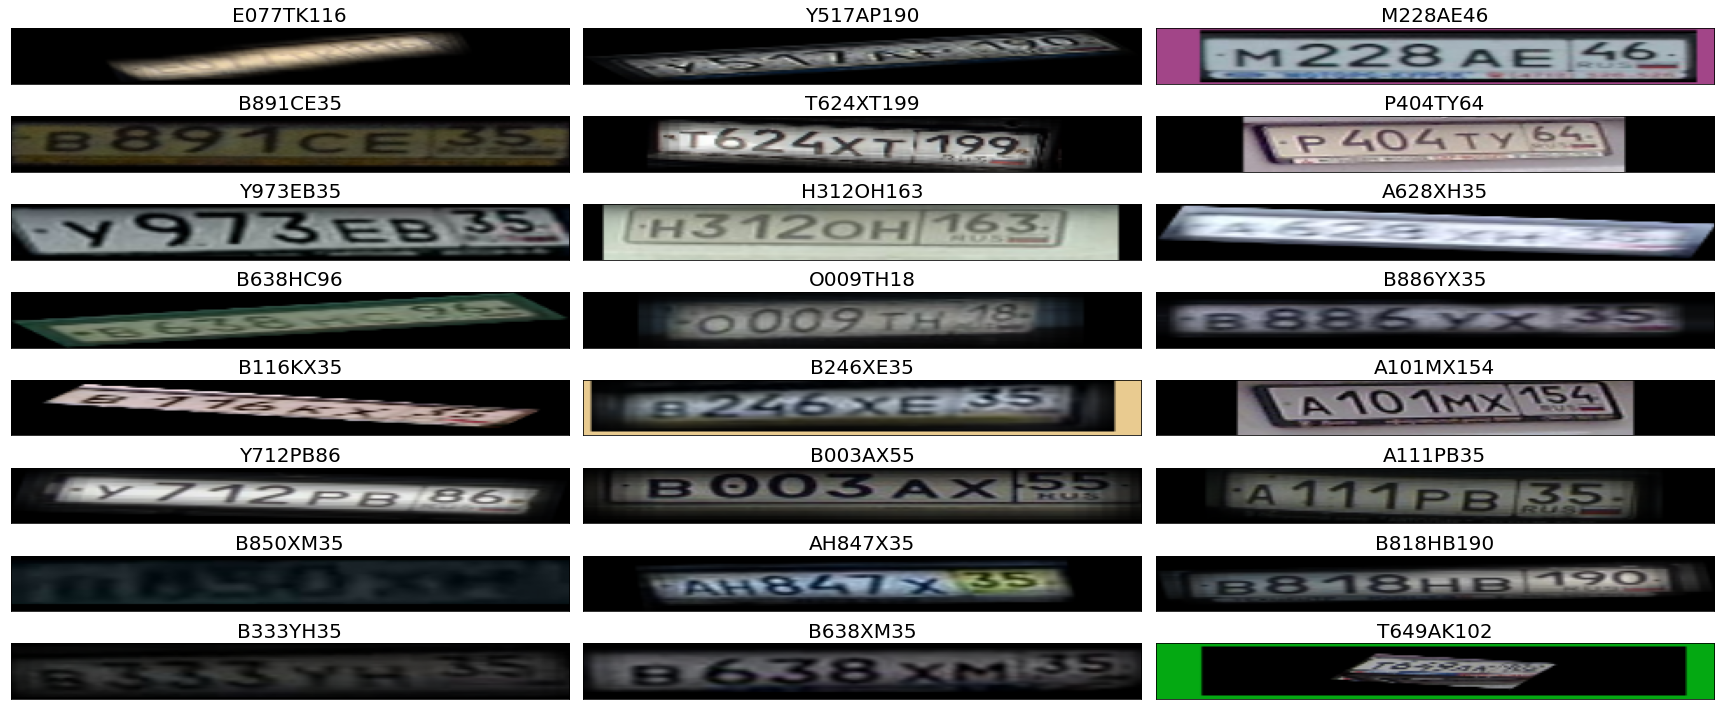

In [6]:
plt.figure(figsize=(24,10))
for i in range(24):
    plt.subplot(8,3,i+1)
    sample = train_dataset[i]
    plt.imshow(sample['image'])
    plt.title(sample['text'], size=20)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

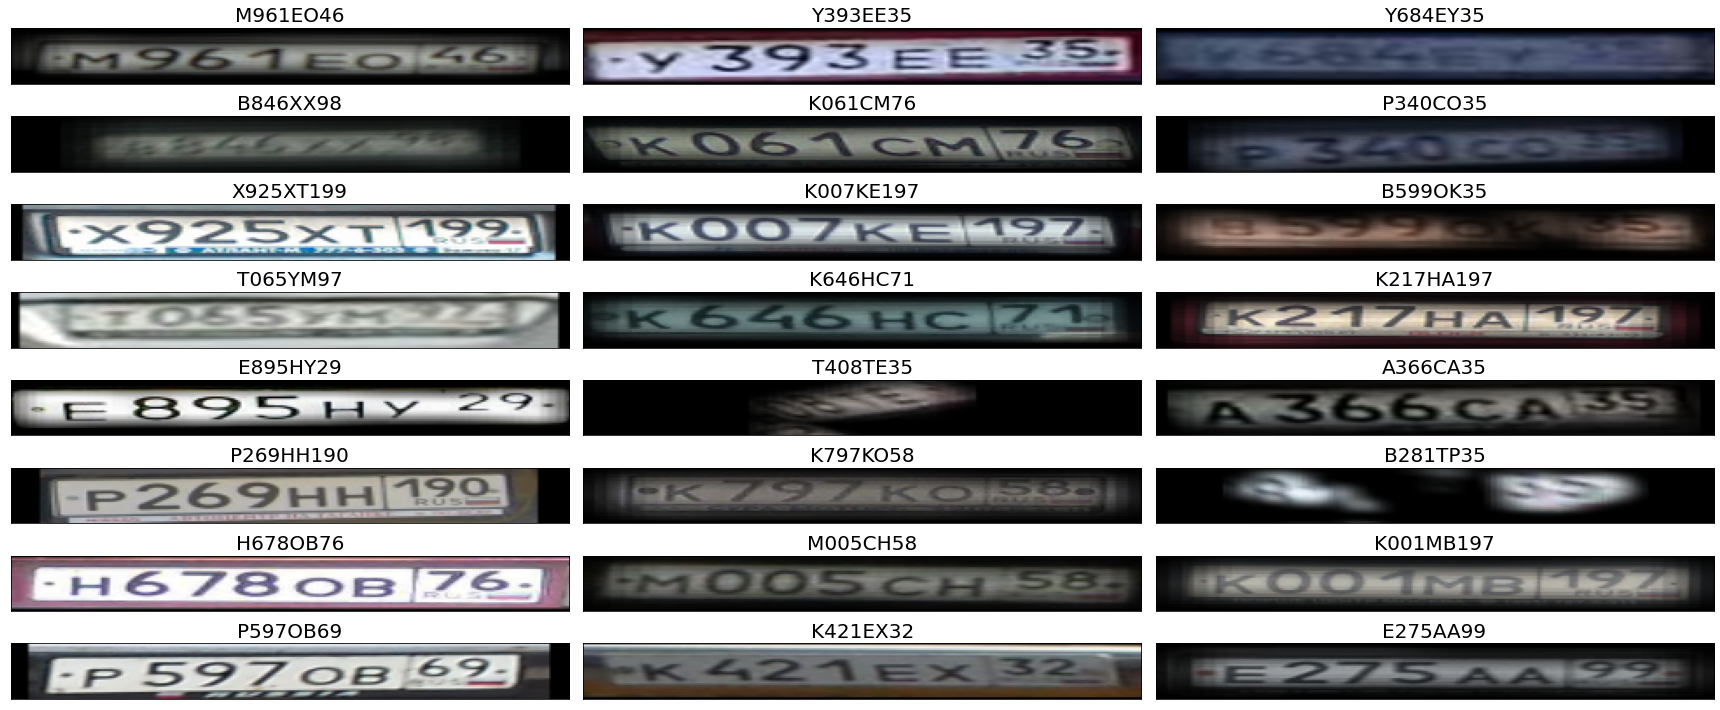

In [7]:
plt.figure(figsize=(24,10))
for i in range(24):
    plt.subplot(8,3,i+1)
    sample = val_dataset[i]
    plt.imshow(sample['image'])
    plt.title(sample['text'], size=20)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [8]:
class RecognitionModel(nn.Module):
    def __init__(self, dropout=0.3, num_directions=1):
        # see workshop #9 for more details
        # (https://github.com/BorisLestsov/MADE/blob/master/seminar9-carocr/9%20-%20crnn%20-%20completed.ipynb)
        super(RecognitionModel, self).__init__()
        self.abc = abc
        self.num_classes = len(self.abc)
        self.num_directions = num_directions
        
        self.cnn = build_FE()

        self.proj = nn.Conv2d(10, 24, kernel_size=1)
        # TODO: move these parameters to the constructor function in order experiment using factories & configs
        # TODO: try other RNNs or even CNNs, if you've got enough time
        self.rnn = nn.GRU(input_size=512,
                          hidden_size=128,
                          num_layers=2,
                          batch_first=False,
                          dropout=dropout,
                          bidirectional=(num_directions == 2))

        self.linear = nn.Linear(128 * num_directions, len(abc) + 1, bias=False)
        self.softmax = nn.Softmax(dim=2)

    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.rnn.num_layers * self.num_directions,
                             batch_size,
                             self.rnn.hidden_size)
        hidden = hidden.to(device)
        return hidden

    def forward(self, x, decode=False):
        hidden = self.init_hidden(x.size(0), next(self.parameters()).device)
        features = self.cnn(x)
        sequence = self.features_to_sequence(features)
        sequence, hidden = self.rnn(sequence, hidden)
        sequence = self.linear(sequence)

        if not self.training:
            sequence = self.softmax(sequence)
            if decode:
                sequence = self.decode(sequence)

        return sequence

    def features_to_sequence(self, features):
        b, c, h, w = features.size()
        assert h == 1, '1 != {}'.format(h)
        features = features.permute(0, 3, 2, 1).contiguous()
        features = self.proj(features)
        features = features.permute(1, 0, 2, 3).contiguous()
        features = features.squeeze(2)
        return features

    def get_block_size(self, layer):
        return layer[-1][-1].bn2.weight.size()[0]

    def pred_to_string(self, pred):
        seq = []
        for i in range(len(pred)):
            label = np.argmax(pred[i])
            seq.append(label - 1)
        out = []
        for i in range(len(seq)):
            if len(out) == 0:
                if seq[i] != -1:
                    out.append(seq[i])
            else:
                if seq[i] != -1 and seq[i] != seq[i - 1]:
                    out.append(seq[i])
        out = ''.join([self.abc[c] for c in out])
        return out

    def decode(self, pred):
        pred = pred.permute(1, 0, 2).cpu().data.numpy()
        outputs = []
        for i in range(len(pred)):
            outputs.append(self.pred_to_string(pred[i]))
        return outputs

In [9]:
logger = get_logger('train.log')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = RecognitionModel(RNN_DROPOUT, RNN_NUM_DIRECTIONS)

if START_CHECKPOINT is not None:
    net.load_state_dict(torch.load(START_CHECKPOINT))

net = net.to(device)
criterion = ctc_loss
logger.info('Model type: {}'.format(net.__class__.__name__))

# TODO: try other optimizers and schedulers
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP, gamma=LR_GAMMA) if LR_STEP > 0 else None



# TODO: maybe implement batch_sampler for tackling imbalance, which is obviously huge in many respects
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=train_dataset.collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=val_dataset.collate_fn)
logger.info('Length of train/val=%d/%d', len(train_dataset), len(val_dataset))
logger.info('Number of batches of train/val=%d/%d', len(train_dataloader), len(val_dataloader))

try:
    metrics = train(net, criterion, optimizer, scheduler, train_dataloader, val_dataloader, epochs=EPOCHS, logger=logger, device=device)
except KeyboardInterrupt:
    torch.save(net.state_dict(), 'INTERRUPTED.pth')
    logger.info('Saved interrupt')
    sys.exit(0)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


2020-06-20 16:29:41 Model type: RecognitionModel
2020-06-20 16:29:41 Length of train/val=98602/24650
2020-06-20 16:29:41 Number of batches of train/val=386/97
2020-06-20 16:29:41 Starting epoch 1/100.
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 386/386 [01:42<00:00,  3.77it/s]
2020-06-20 16:31:23 Epoch finished! Loss: 1.79494
100%|██████████| 97/97 [00:13<00:00,  7.05it/s]
2020-06-20 16:31:37 Valid acc: 0.35124, acc_ed: 1.74755 (best)
2020-06-20 16:31:37 Starting epoch 2/

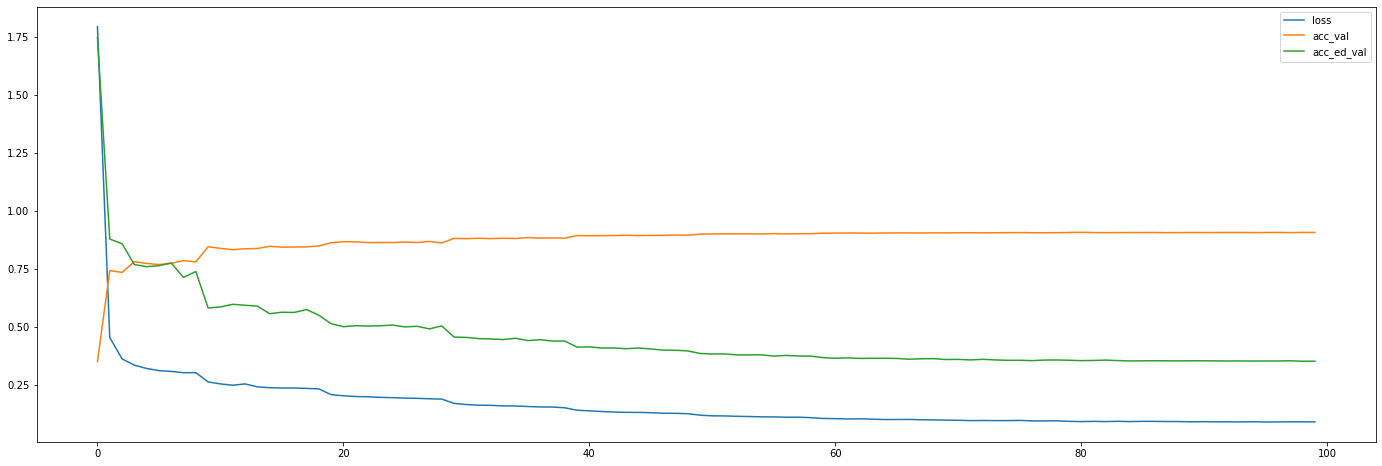

In [10]:
plt.figure(figsize=(24,8));
for name,values in metrics.items():
    plt.plot(values, label=name)
plt.legend()
plt.show();

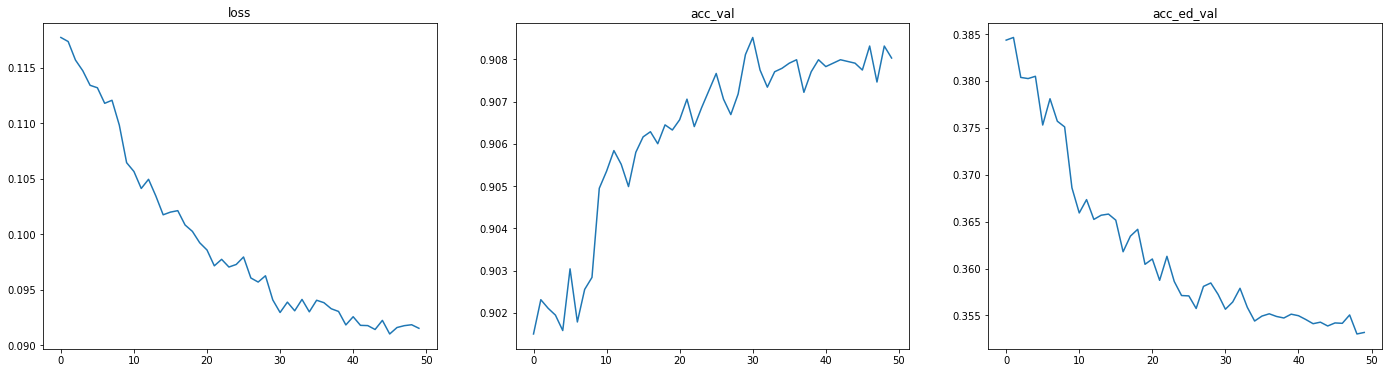

In [11]:
plt.figure(figsize=(24,6));
for i,(name,values) in enumerate(metrics.items()):
    plt.subplot(1,len(metrics),i+1)
    plt.plot(values[len(values)//2:])
    plt.title(name);

In [12]:
%%time
test_storage = RecognitionDataStorage(TEST_META, TEST_CROPS, limit=None, only_valid=False)

test_transforms = Resize(size=CROP_SIZE)

test_dataset = RecognitionDataset(test_storage, np.arange(len(test_storage)), abc=abc, transforms=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=test_dataset.collate_fn)
print(len(test_storage))

41146
CPU times: user 8.44 s, sys: 1.39 s, total: 9.83 s
Wall time: 9.87 s


In [13]:
def predict(model,dataloader):
    texts = []
    filenames = []
    orders = []
    result={}
    with torch.no_grad():
        model.eval()
        for j, batch in enumerate(tqdm.tqdm(dataloader)):
            batch_images = batch['images'].to(device)
            batch_texts = model(batch_images, decode=True)
            for filename, order, text in zip(batch['filenames'], batch['orders'], batch_texts):
                if filename not in result:
                    result[filename] = list()
                result[filename].append((order, text))
    return result

In [14]:
prediction = predict(net, test_dataloader)

100%|██████████| 161/161 [00:20<00:00,  7.68it/s]


In [15]:
torch.save(prediction, "prediction.pth")

# Generate a submission file
submission_template=pd.read_csv(SUBMISSION_TEMPLATE)
with open('submission.csv', 'w') as wf:
    wf.write('file_name,plates_string\n')
    for file_name in submission_template.file_name.values:
        texts = prediction[file_name] if file_name in prediction else [(0,"")]
        texts.sort(key=lambda x: x[0])
        wf.write('%s,%s\n' % (file_name, ' '.join([w[1] for w in texts])))

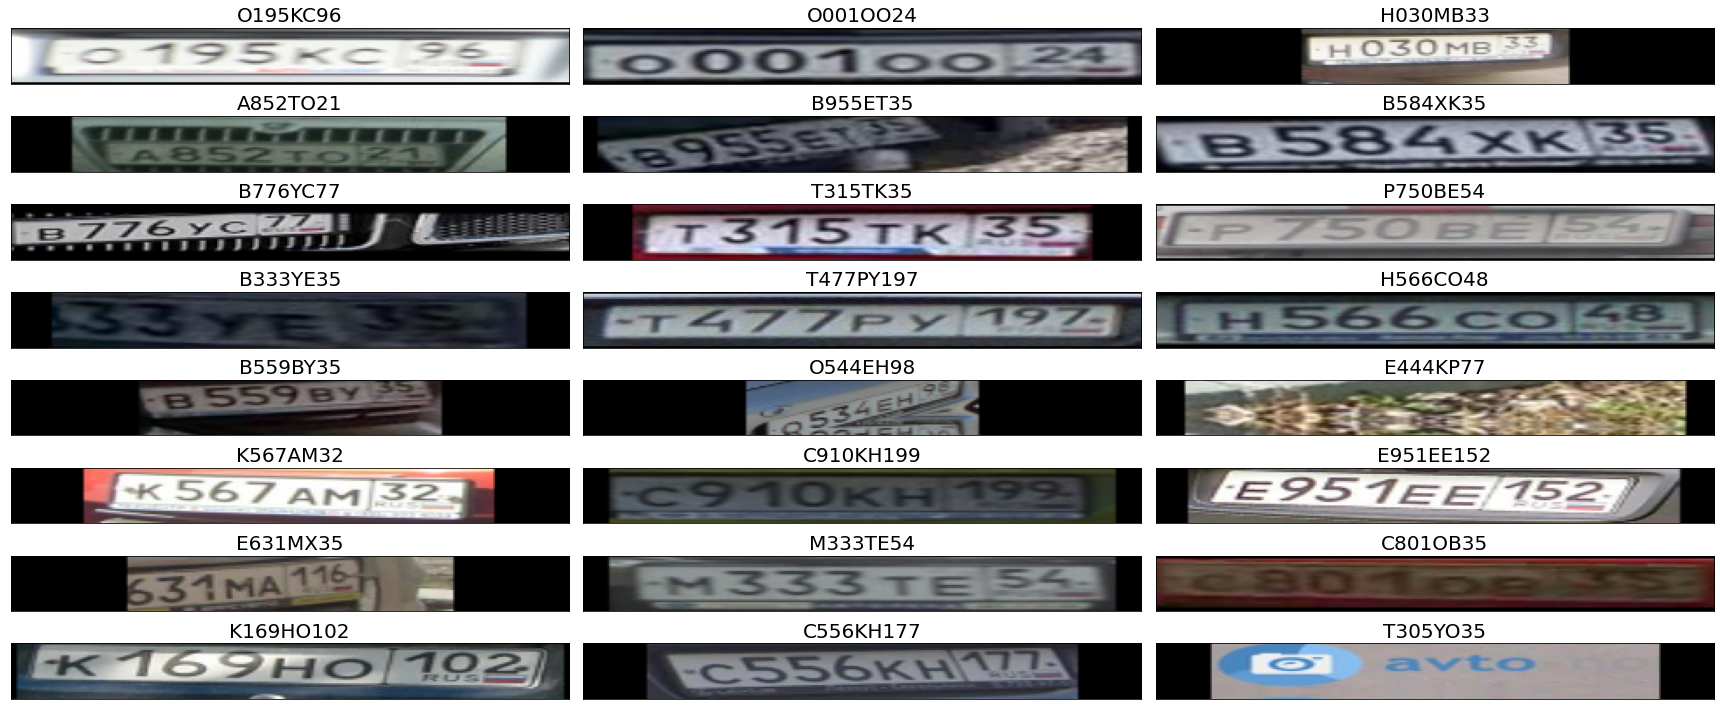

In [16]:
plt.figure(figsize=(24,10))
for i in range(24):
    plt.subplot(8,3,i+1)
    sample = test_dataset[i]
    pred = ""
    for order, text in prediction[sample['filename']]:
        if order==sample['order']:
            pred = text
    plt.imshow(sample['image'])
    plt.title(pred, size=20)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

100%|██████████| 97/97 [00:12<00:00,  8.05it/s]


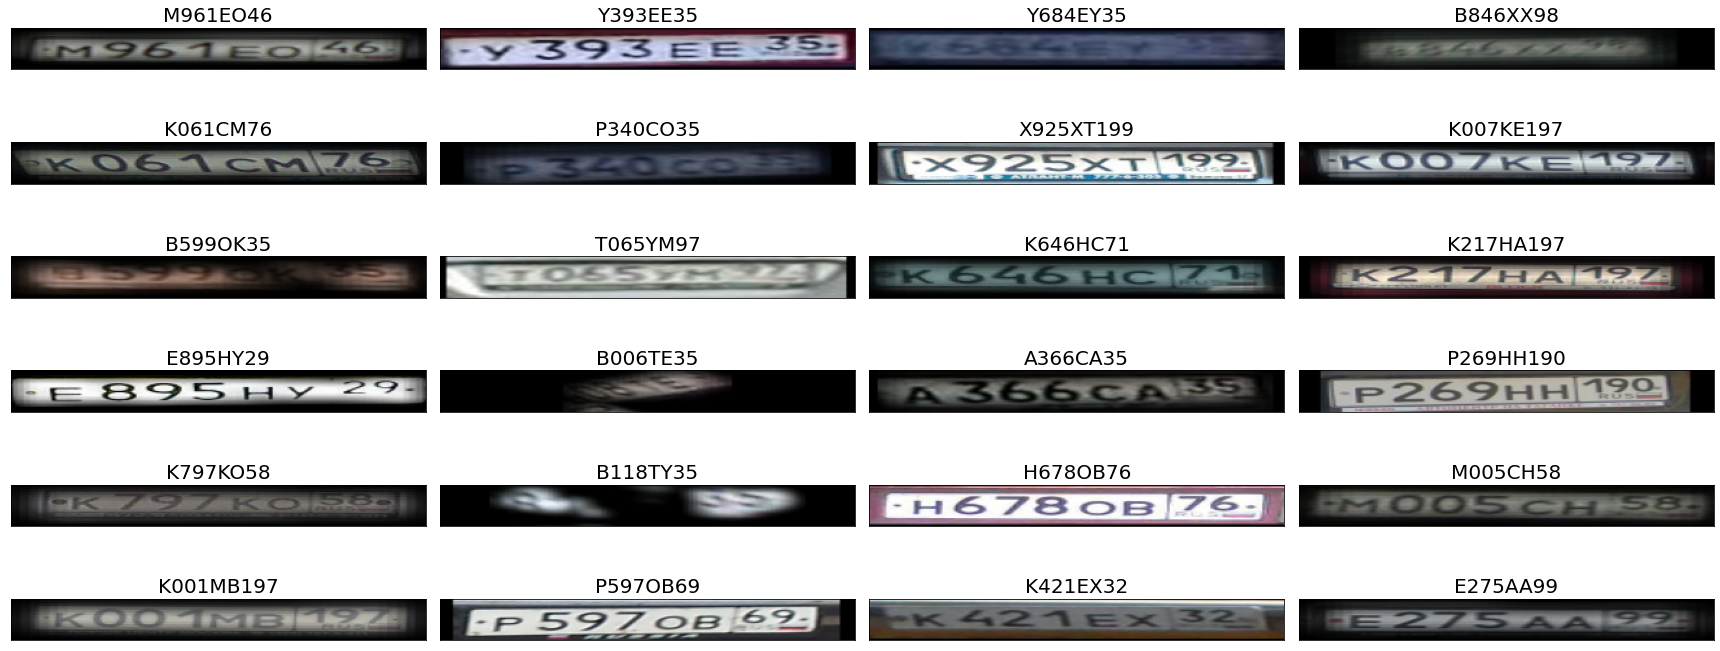

In [17]:
val_prediction = predict(net, val_dataloader)
plt.figure(figsize=(24,10))
for i in range(24):
    plt.subplot(6,4,i+1)
    sample = val_dataset[i]
    pred = ""
    for order, text in val_prediction[sample['filename']]:
        if order==sample['order']:
            pred = text
    plt.imshow(sample['image'])
    plt.title(pred, size=20)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [18]:
!ls -l

total 97176
---------- 1 root root    15698 Jun 20 16:28 __notebook__.ipynb
-rw-r--r-- 1 root root 47951308 Jun 20 19:05 cp-best.pth
-rw-r--r-- 1 root root 47951308 Jun 20 19:42 cp-last.pth
-rw-r--r-- 1 root root  3146930 Jun 20 19:43 prediction.pth
-rw-r--r-- 1 root root   418730 Jun 20 19:43 submission.csv
-rw-r--r-- 1 root root    16323 Jun 20 19:42 train.log
